In [3]:
# numerical / scientific
import numpy as np
import torch
import gpytorch as gp

# plotting
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 5)

# utility imports
from utilities.processing_utility import get_q_2_cw_data 

# strategies imports
from strategies.gp_prediction import *

In [4]:
df = get_q_2_cw_data()

[*********************100%***********************]  1 of 1 completed


In [5]:
# get train test split
split_idx = int(len(df) * 0.7)
excess_return_data = torch.tensor(df['normalised_excess_returns'].to_numpy(), dtype=torch.float32)
price_data = torch.tensor(df['adjusted_close_price'].to_numpy(), dtype=torch.float32)
x_data = torch.arange(0, len(price_data), dtype=torch.float32)

r_train, r_test = get_train_test_split(series = excess_return_data, split_index = split_idx)
p_train, p_test = get_train_test_split(series = price_data, split_index = split_idx)
x_train, x_test = get_train_test_split(series = x_data, split_index = split_idx)

Text(0.5, 1.0, 'S&P 500 normalised Excess Returns')

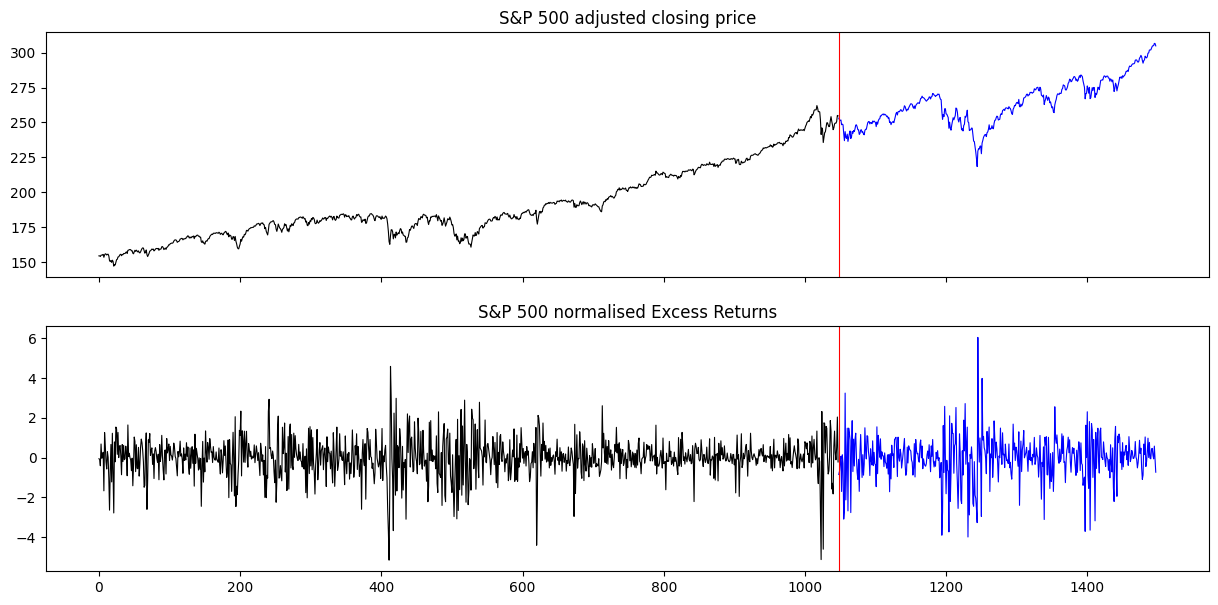

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 7))

# plot the original price series
ax1.plot(x_train, p_train, color = 'black', lw = 0.8, alpha = 1)
ax1.plot(x_test, p_test, color = 'blue', lw = 0.8, alpha = 1)
ax1.axvline(x = len(r_train), color = 'red', lw = 0.8, alpha = 1)
ax1.set_title('S&P 500 adjusted closing price')

# plot the normalised excess returns
ax2.plot(x_train, r_train, color = 'black', lw = 0.8, alpha = 1)
ax2.plot(x_test, r_test, color = 'blue', lw = 0.8, alpha = 1)
ax2.axvline(x = len(r_train), color = 'red', lw = 0.8, alpha = 1)
ax2.set_title('S&P 500 normalised Excess Returns')

In [7]:
# optimise the likelihood
lengthscale_hat, noise_hat = 0.4, 0.45

In [79]:
# take a 20 sample of the training points for development
r = r_train[:20]
p = p_train[:20]
x = x_train[:20]

# get the test point
r_test_point = r_train[20]
p_test_point = p_train[20]
x_test_point = x_train[20]

In [83]:
def plot_time_series(x, r):
    plt.scatter(x, r, marker = '+', color = 'black')
    plt.plot(x, r, color = 'black', lw = 0.8, alpha = 0.9)

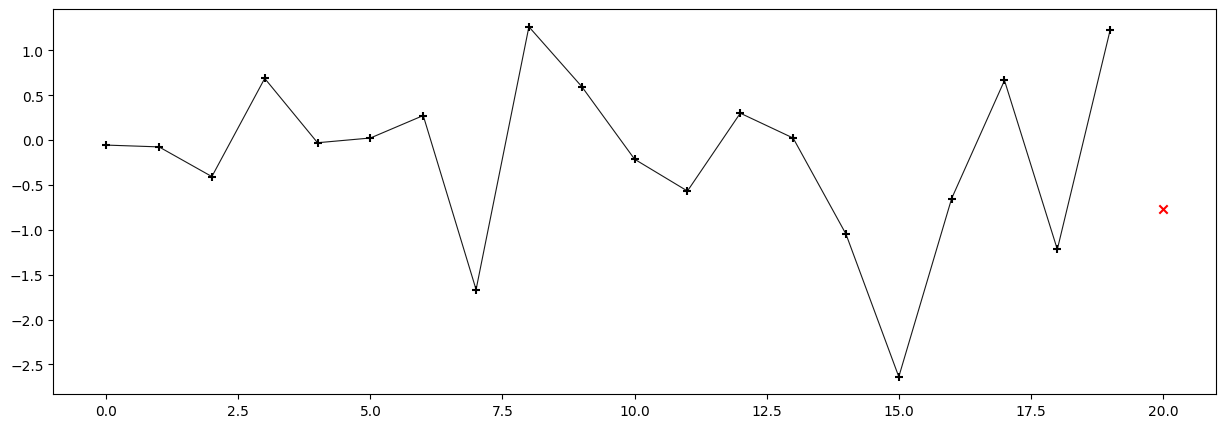

In [84]:
plot_time_series(x, r)
plt.scatter(x_test_point, r_test_point, marker = 'x', color = 'red')

In [85]:
# this what we are trying to model with a gp regression
# the objective is to predict the movement of this excess return series 

In [86]:
# try and fit a GP
gp_model = get_gp(x, r, length_scale = lengthscale_hat, noise = noise_hat)
x_star = get_x_star(x)
f_preds = get_gp_posterior(gp_model, x_star)
lower, upper = f_preds.confidence_region()

observed_pred = get_gp_posterior_predictive(gp_model, gp_model.likelihood, x_star)
lower, upper = observed_pred.confidence_region()

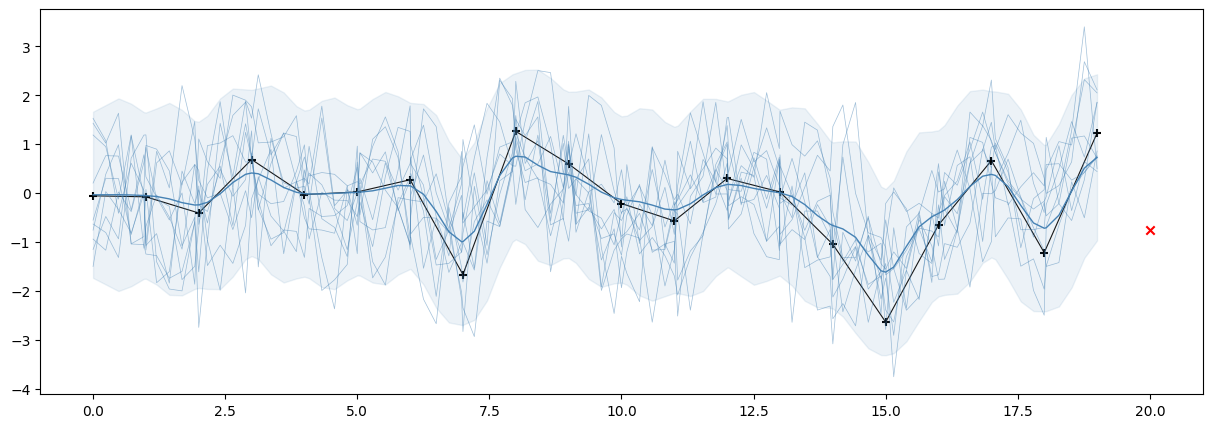

In [88]:
# make plot
plot_time_series(x, r)
plt.plot(x_star, f_preds.mean, color = 'steelblue', lw=1)
plt.fill_between(x_star, lower, upper, color='steelblue', alpha=0.1)

for i in range(10):
    plt.plot(x_star, observed_pred.sample(), color = 'steelblue', lw=0.5, alpha=0.5)

plt.scatter(x_test_point, r_test_point, marker = 'x', color = 'red')

In [194]:
from PIL import Image
import os
import shutil

def save_to_gif(
    figure_list : List[plt.Figure],
    gif_name : str,
    gif_duration : int = 500,
    ) -> None:
    """
    Saves a gif from a given figure list.

    Arugments:
    ----------
    figure_list     : {List[plt.Figure]}
                        > List of figures to save as a gif.
    gif_name        : {str}
                        > Name of the gif to be saved.
    gif_duration    : {int}
                        > Duration of each frame in the gif.
    
    Returns:
    ----------
    None
    """
    # check if temp directory exists
    if os.path.exists("temp"):
        # delete the directory
        shutil.rmtree("temp")
        os.mkdir("temp")
    else: 
        os.mkdir("temp")

    # Create a list of image file names
    image_filenames = []
    for i, fig in enumerate(figure_list):
        filename = f"figure_{i}.png"
        fig.savefig(os.path.join("temp", filename))
        image_filenames.append(filename)

    # Open the first image and get its size
    with Image.open(os.path.join("temp", image_filenames[0])) as im:
        width, height = im.size

    # Create a new image object with the same size as the first image
    gif_image = Image.new('RGB', (width, height))

    # Open each image file and add it to the GIF image
    gif_frames = []
    for filename in image_filenames:
        with Image.open(os.path.join("temp", filename)) as im:
            gif_frames.append(im.copy())
    
    # Save the GIF
    gif_image.save(gif_name, save_all=True, append_images=gif_frames, duration=gif_duration, loop=50)

    # Delete the temporary directory
    shutil.rmtree("temp")
    

In [222]:
# take a 20 sample of the training points for development
n_points = 250

r = r_train[:n_points]
p = p_train[:n_points]
x = x_train[:n_points]

# get the test point
r_test_point = r_train[n_points]
p_test_point = p_train[n_points]
x_test_point = x_train[n_points]

In [223]:
# optimise the likelihood
lengthscale_hat, noise_hat = 2.5, 0.45

In [227]:
figures = []

predictions = []
prediction_upper = []
prediction_lower = []

# sequential prediction
for i in range(len(x[:-1])):
    # test point
    r_test_point = r[i]
    x_test_point = x[i]

    # train points
    r_train_points = r[:i]
    x_train_points = x[:i]

    # all points
    x_all_points = torch.cat([x_train_points, x_test_point.unsqueeze(-1)])

    # try and fit a GP
    gp_model = get_gp(x_train_points, r_train_points, length_scale = lengthscale_hat, noise = noise_hat)
    f_preds = get_gp_posterior(gp_model, x_all_points)
    lower_train, upper_train = f_preds.confidence_region()
    
    prediction = get_gp_posterior_predictive(gp_model, gp_model.likelihood, x_test_point.unsqueeze(-1))
    prediction = get_gp_posterior(gp_model, x_test_point.unsqueeze(-1))
    lower_pred, upper_pred = prediction.confidence_region()

    # save the predictions
    predictions.append(prediction.mean[-1].item())
    prediction_upper.append(upper_pred[-1].item())
    prediction_lower.append(lower_pred[-1].item())

    # make plot
    fig = plt.figure()

    # set y lime
    plt.ylim(-3, 3)

    # plot the previous training points
    for j in range(len(x_train_points)):
        plt.scatter(x_train_points[j].item(), r_train_points[j], marker = '+', color = 'black', alpha = 1)
        plt.scatter(x_train_points[j].item(), f_preds.mean[j].item(), marker = '+', color='red', alpha=1)
        plt.fill_between(x_train_points[j].unsqueeze(-1), lower_train[j], upper_train[j], color='red', alpha=.5)

    # plot the test point
    plt.scatter(x_test_point.item(), r_test_point, marker = '+', color = 'blue', alpha = 1)
    plt.scatter(x_test_point.item(), prediction.mean[-1].item(), marker = '+', color='red', alpha=1)
    plt.fill_between(x_test_point.unsqueeze(-1), lower_pred[-1], upper_pred[-1], color='red', alpha=.5)

    plt.axhline(0, color = 'black', linestyle = '--', alpha = 1)

    # append figure
    figures.append(fig)
    plt.close()





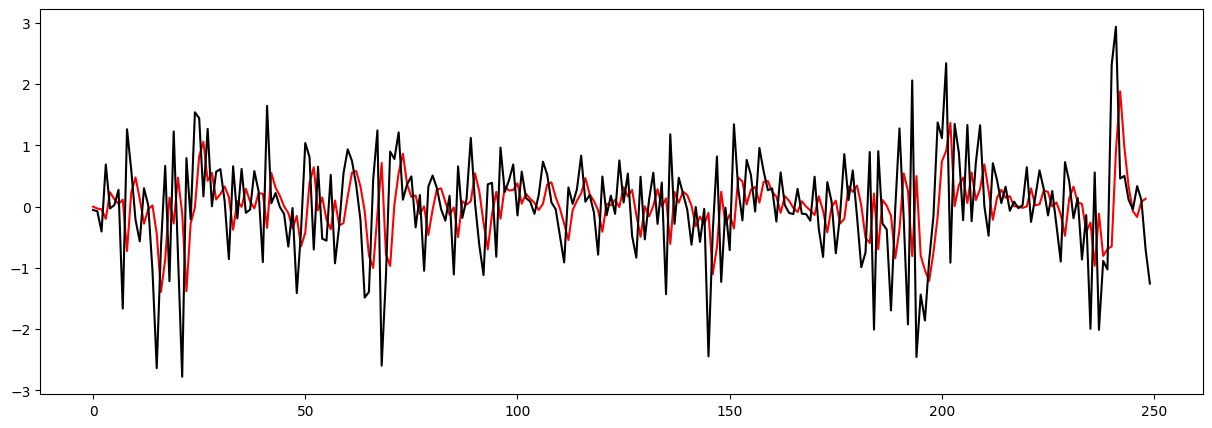

In [228]:
plt.plot(predictions, color = 'red')
plt.plot(r, color = 'black')

In [234]:
np.unique(np.array(prediction_lower) - np.array(prediction_upper))

array([-3.33021855, -2.31516695, -2.22044897, -2.21991754, -2.20826703,
       -2.20408589, -2.20405698, -2.20366669, -2.20348239, -2.20344996,
       -2.20343751, -2.20343614, -2.20343065, -2.20343018, -2.20342994,
       -2.20342946, -2.20342928, -2.20342898, -2.20342875, -2.20342636,
       -2.20342594, -2.20342565, -2.20342517, -2.20342398, -2.2034238 ,
       -2.20342231, -2.20342213, -2.20342183, -2.20342159, -2.20342135,
       -2.20342064, -2.20341986, -2.20341969, -2.20341927, -2.20341921,
       -2.20341873, -2.20341706, -2.20341682, -2.20341635, -2.20341611,
       -2.20341516, -2.2034142 , -2.20341355, -2.20341349, -2.20341325,
       -2.20341301, -2.20341229, -2.20341206, -2.20341194, -2.20341158,
       -2.20341134, -2.20341128, -2.2034111 , -2.20341063, -2.20341057,
       -2.20341015, -2.20340991, -2.20340973, -2.20340967, -2.20340878,
       -2.20340872, -2.20340824, -2.203408  , -2.20340776, -2.20340753,
       -2.20340729, -2.20340705, -2.20340681, -2.20340651, -2.20

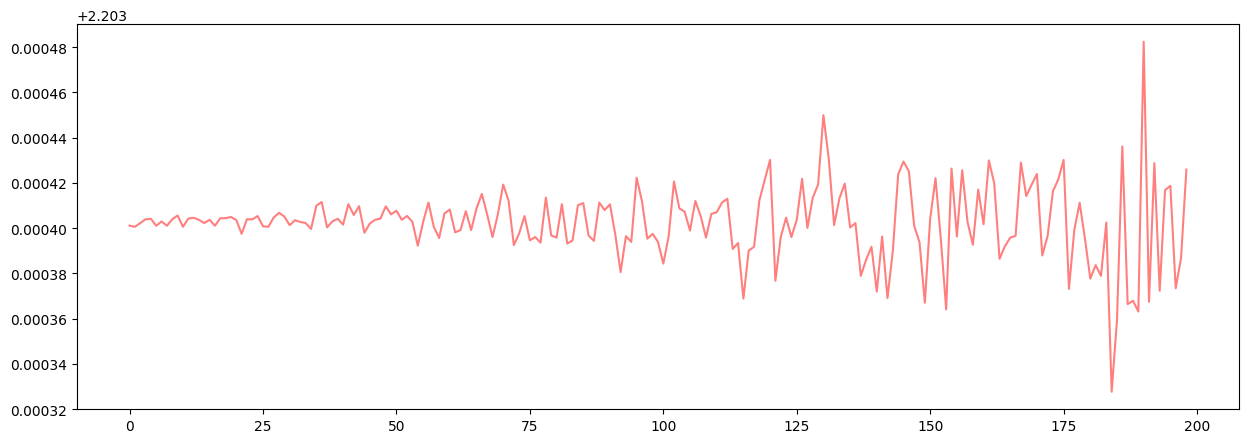

In [237]:
plt.plot(abs(np.array(prediction_upper[50:]) - np.array(prediction_lower[50:])), color = 'red', alpha = 0.5)

In [225]:
save_to_gif(
    figure_list = figures,
    gif_name = "gp_prediction_only.gif",
    gif_duration = 500,
    )

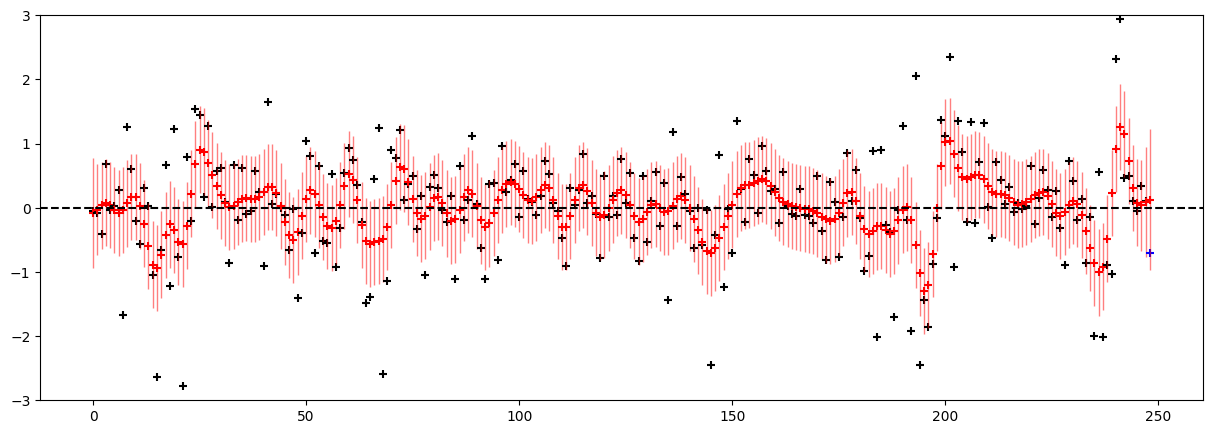

In [226]:
figures[-1]

In [221]:
# take a 20 sample of the training points for development
n_points = 100

r = r_train[:n_points]
p = p_train[:n_points]
x = x_train[:n_points]

# get the test point
r_test_point = r_train[n_points]
p_test_point = p_train[n_points]
x_test_point = x_train[n_points]

x_star = x_train[:n_points+1]

In [198]:
# optimise the likelihood
lengthscale_hat, noise_hat = 2.5, 0.45

In [206]:
figures = []

# sequential prediction
for i in range(len(x[:-1])):
    # test point
    r_test_point = r[i]
    x_test_point = x[i]

    # train points
    r_train_points = r[:i]
    x_train_points = x[:i]

    # try and fit a GP
    gp_model = get_gp(x_train_points, r_train_points, length_scale = lengthscale_hat, noise = noise_hat)
    f_preds = get_gp_posterior(gp_model, x_star)
    lower_train, upper_train = f_preds.confidence_region()

    # make plot
    fig = plt.figure()

    plt.ylim(-3, 3)

    plt.plot(x_train_points, r_train_points, marker = 'x', color = 'black', alpha = 1)
    plt.plot(x_star, f_preds.mean, color='red', alpha=1)
    plt.fill_between(x_star, lower_train, upper_train, color='red', alpha=.1)

    for i in range(25):
        plt.plot(x_star, f_preds.sample(), color='red', alpha=.1)

    plt.axhline(0, color='black', linestyle='--', alpha = .75)

    # append figure
    figures.append(fig)

    plt.close()





In [208]:
save_to_gif(
    figure_list = figures,
    gif_name = "fitting_gp.gif",
    gif_duration = 500,
    )

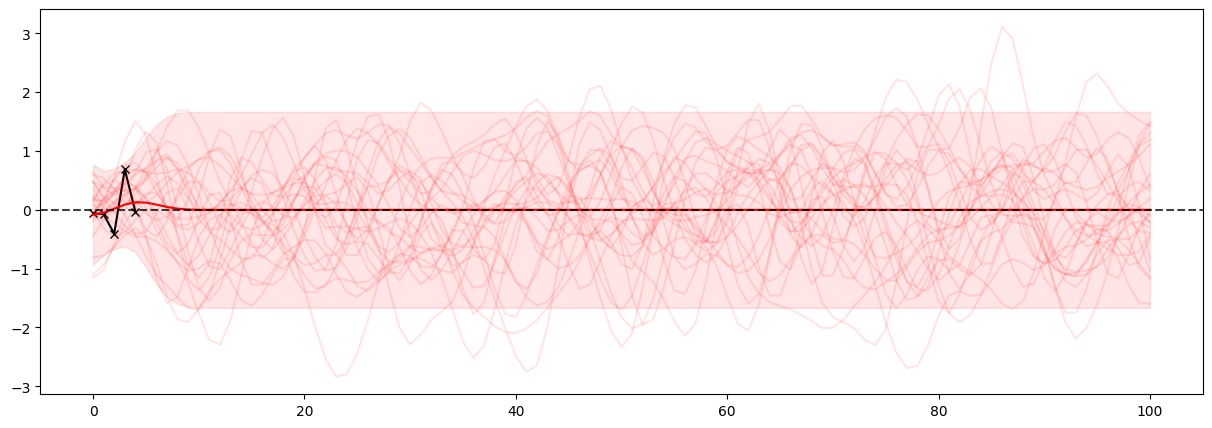

In [201]:
figures[5]

# Prediction Strategy : BUY / SELL EVERYPOINT

In [ ]:
# optim
# lengthscale_hat, noise_hat = 2.5, 0.45
# stop loss < 0.98
# lookback = 10

In [425]:
# take a 20 sample of the training points for development
lengthscale_hat, noise_hat = .5, 0.45
n_points = -1

returns = r_train[:n_points]
prices = p_train[:n_points]
Xs = x_train[:n_points]

# strategy setup
w = torch.zeros(np.shape(prices))
strategy_returns = torch.zeros(np.shape(prices))

cash = torch.zeros(np.shape(prices))
cash[0] = 1

for i, (p, r, x) in enumerate(zip(prices[:-1], returns[:-1], Xs[:-1])):
    
    # test point
    r_test_point = returns[i]
    p_test_point = prices[i]
    x_test_point = Xs[i]

    # train points
    r_train_points = returns[:i]
    p_train_points = prices[:i]
    x_train_points = Xs[:i]

    # fit GP
    gp_model = get_gp(x_train_points, r_train_points, length_scale = lengthscale_hat, noise = noise_hat)

    # get the poseterior
    f_preds = get_gp_posterior(gp_model, x.unsqueeze(-1))
    lower_train, upper_train = f_preds.confidence_region()

    # get the posterior predictive
    x_pred = get_gp_posterior_predictive(gp_model, gp_model.likelihood, x_test_point.unsqueeze(-1))
    x_pred_mean = x_pred.mean.item()
    x_pred_lower, x_pred_upper = prediction.confidence_region()

    # get current strategy returns
    strategy_returns[i] = w[i] * p + cash[i]

    if i < 10:
        w[i+1] = w[i]
        cash[i+1] = cash[i]
        continue

    # sell
    if strategy_returns[i] / strategy_returns[i-10] < .98:
        cash[i+1] = w[i]*p + cash[i]
        w[i+1] = 0
        continue

    # buy
    if x_pred_mean > r:
        w[i+1] = cash[i] / p + w[i] 
        cash[i+1] = 0
        continue
    
    # sell
    if x_pred_mean < r:
        cash[i+1] = w[i]*p + cash[i]
        w[i+1] = 0
        continue

strategy_return = w * prices + cash
 

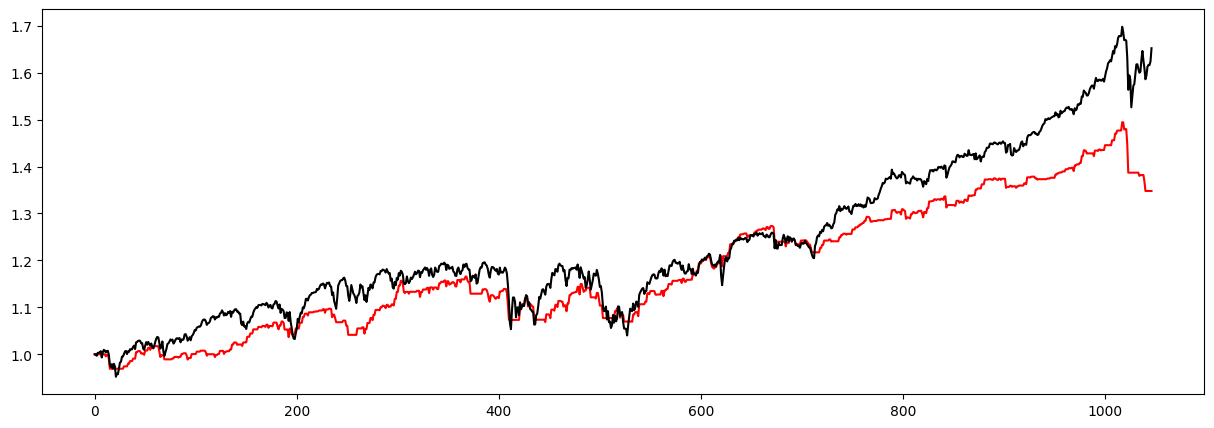

In [426]:
plt.plot(strategy_return, color = 'red')
plt.plot(prices/prices[0], color = 'black')

In [445]:
# take a 20 sample of the training points for development
lengthscale_hat, noise_hat = .5, 0.45
n_points = -1

returns = r_test[:n_points]
prices = p_test[:n_points]
Xs = x_test[:n_points]

# strategy setup
w = torch.zeros(np.shape(prices))
strategy_returns = torch.zeros(np.shape(prices))

cash = torch.zeros(np.shape(prices))
cash[0] = 1

for i, (p, r, x) in enumerate(zip(prices[:-1], returns[:-1], Xs[:-1])):
    
    # test point
    r_test_point = returns[i]
    p_test_point = prices[i]
    x_test_point = Xs[i]

    # train points
    r_train_points = returns[:i]
    p_train_points = prices[:i]
    x_train_points = Xs[:i]

    # fit GP
    gp_model = get_gp(x_train_points, r_train_points, length_scale = lengthscale_hat, noise = noise_hat)

    # get the poseterior
    f_preds = get_gp_posterior(gp_model, x.unsqueeze(-1))
    lower_train, upper_train = f_preds.confidence_region()

    # get the posterior predictive
    x_pred = get_gp_posterior_predictive(gp_model, gp_model.likelihood, x_test_point.unsqueeze(-1))
    x_pred_mean = x_pred.mean.item()
    x_pred_lower, x_pred_upper = prediction.confidence_region()

    # get current strategy returns
    strategy_returns[i] += w[i] * p + cash[i]



    if i < 10:
        w[i+1] = w[i]
        cash[i+1] = cash[i]
        continue


    if torch.mean(pct_diff[-10:]).item() < 0:
        
        cash[i+1] = w[i]*p + cash[i]
        w[i+1] = 0
        continue


    # if strategy_returns[i] / strategy_returns[i-10] < .98:
    #     cash[i+1] = w[i]*p + cash[i]
    #     w[i+1] = 0
    #     continue

    # # if in window, hold
    # if abs(x_pred_mean) < .75:
    #     w[i+1] = w[i]
    #     cash[i+1] = cash[i]
    #     continue

    # buy
    if x_pred_mean > r:
        w[i+1] = cash[i] / p + w[i] 
        cash[i+1] = 0
        continue
    
    # sell
    if x_pred_mean < r:
        cash[i+1] = w[i]*p + cash[i]
        w[i+1] = 0
        continue

strategy_return = w * prices + cash
 

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 

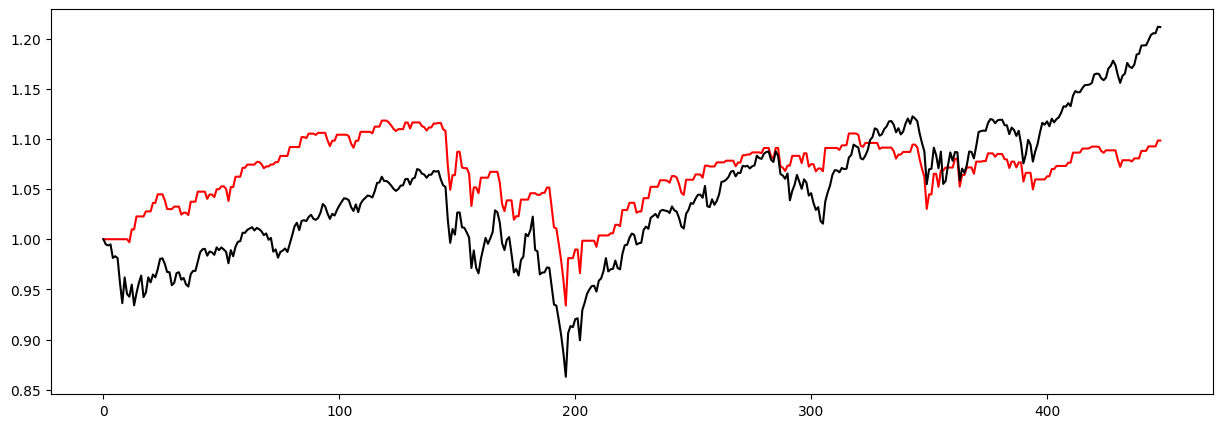

In [438]:
plt.plot(strategy_return, color = 'red')
plt.plot(prices/prices[0], color = 'black')

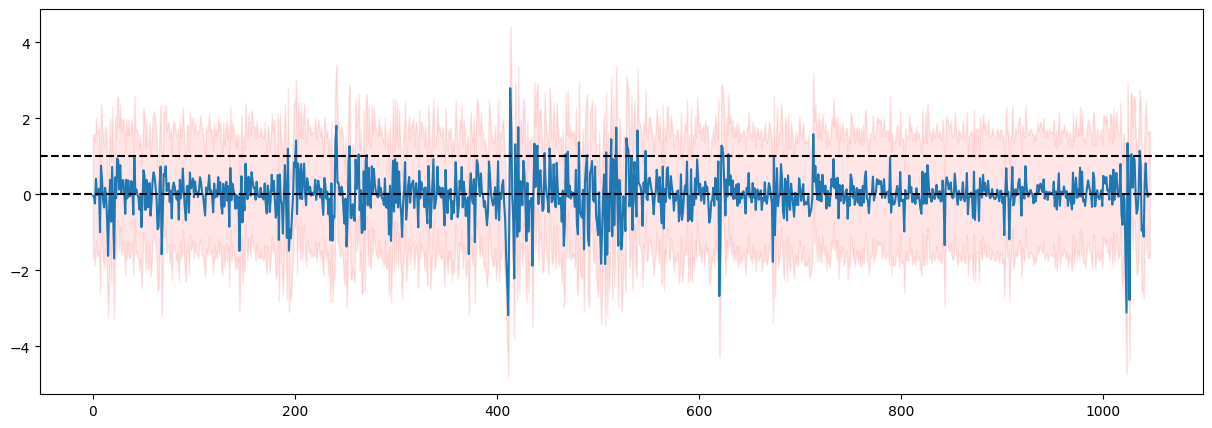

In [310]:
f_preds = get_gp_posterior(gp_model, Xs)
lower, upper = f_preds.confidence_region()

plt.plot(f_preds.mean)
plt.fill_between(Xs, lower, upper, color='red', alpha=.1)

plt.axhline(0, color = 'black', linestyle = '--', alpha = 1)
plt.axhline(1, color = 'black', linestyle = '--', alpha = 1)

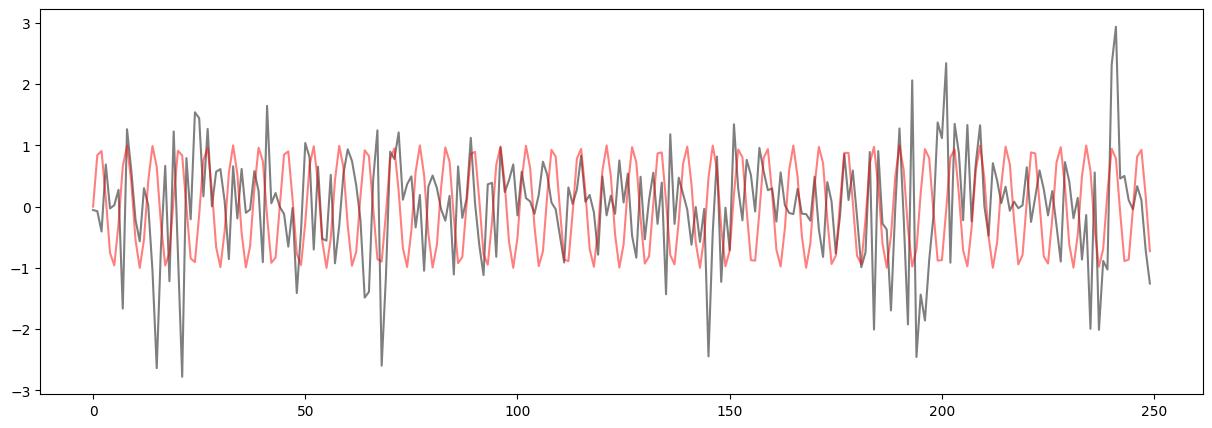

In [355]:
plt.plot(returns, color = 'black', alpha = .5)
plt.plot(torch.sin(Xs), color = 'red', alpha = .5)